# 傾向スコアとは

傾向スコアは、観察研究において共変量を調整するための統計手法であり、因果効果を推定するために用いられる。無作為化が難しい研究において、交絡因子を制御することが可能。

傾向スコアは、介入群と非介入群に分けられた状況で、介入群と非介入群の共変量の分布を調整するために使われ、共変量の分布を調整することによって、介入群と非介入群の比較をより正確に行うことができる。

傾向スコアの用途と利点には以下のようなものがある。

- 共変量の影響を調整し、因果関係を推定するために使われる。
- 無作為割付が困難な場合に、介入効果の推定を行うために使われる。
- 研究デザインを改善するための代替方法として使われる。
- 傾向スコアを用いることで、介入群と非介入群のバランスが改善され、効果推定の信頼性が向上することが期待される。

In [1]:
import pandas as pd
import os
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tqdm import tqdm_notebook
import random
import numpy as np
import warnings
warnings.simplefilter("ignore")

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Noto Sans CJK JP'

# Load Data

In [2]:
dumped_male_df_path = "../data/male_df.joblib"
dumped_biased_df_path = "../data/biased_df.joblib"

if not os.path.exists("../data"):
    os.makedirs("../data", exist_ok=True)

if os.path.exists(dumped_male_df_path):
    male_df = joblib.load(dumped_male_df_path)
    biased_data = joblib.load(dumped_biased_df_path)

else:
    mail_df = pd.read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
    male_df = mail_df[mail_df["segment"]!="Womens E-Mail"].copy()
    male_df["treatment"] = male_df["segment"].apply(lambda x: 1 if x == "Mens E-Mail" else 0)

    # create bias data
    sample_rules = (male_df.history > 300) | (male_df.recency < 6) | (male_df.channel=='Multichannel')

    biased_data = pd.concat([
        male_df[(sample_rules) & (male_df.treatment == 0)].sample(frac=0.5, random_state=1),
        male_df[(sample_rules) & (male_df.treatment == 1)],
        male_df[(~sample_rules) & (male_df.treatment == 0)],
        male_df[(~sample_rules) & (male_df.treatment == 1)].sample(frac=0.5, random_state=1)
    ], axis=0, ignore_index=True)


    display(biased_data.head())

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
0,8,5) $500 - $750,572.65,1,0,Urban,1,Web,No E-Mail,0,0,0.0,0
1,5,1) $0 - $100,42.38,1,0,Urban,1,Phone,No E-Mail,1,0,0.0,0
2,1,"7) $1,000 +",3003.48,1,1,Urban,1,Phone,No E-Mail,0,0,0.0,0
3,1,5) $500 - $750,662.10,0,1,Urban,1,Web,No E-Mail,0,0,0.0,0
4,5,1) $0 - $100,44.37,0,1,Urban,0,Web,No E-Mail,0,0,0.0,0


In [3]:
biased_data["treatment"].value_counts()

1    17168
0    14757
Name: treatment, dtype: int64

## 3.1.2 Propensity Score Estimation

https://github.com/shyaginuma/cibook-study-python/blob/master/scripts/propensity_score_matching.py

https://www.slideshare.net/okumurayasuyuki/ss-43780294

In [4]:
y = biased_data["treatment"]
X = pd.get_dummies(biased_data[["recency", "channel", "history"]], columns=["channel"], drop_first=True)

print(X.shape)
print(y.shape)
display(X.head())

(31925, 4)
(31925,)


,recency,history,channel_Phone,channel_Web
0,8,572.65,0,1
1,5,42.38,1,0
2,1,3003.48,1,0
3,1,662.10,0,1
4,5,44.37,0,1


In [5]:
class PropensityScoreMatching:
    def __init__(self, bias_data, treatment, control, random_state=0):
        self.bias_data = bias_data
        self.treatment = treatment
        self.control = control
        self.random_state = random_state

        self.y = None
        self.X = None

    def match(self):
        self.y = self.bias_data[self.treatment].copy()
        self.X = self.bias_data[self.control].copy()

        object_columns = self.X.select_dtypes(include="object").columns.tolist()
        if len(object_columns)>0:
            self.X = pd.get_dummies(self.X, columns=object_columns, drop_first=True)

        ps_model = LogisticRegression(solver="lbfgs", random_state=self.random_state)
        ps_model.fit(self.X, self.y)
        ps_score = ps_model.predict_proba(self.X)[:, 1]
        all_df = pd.DataFrame({f"{self.treatment}": self.y, "ps_score": ps_score})

        treatments = all_df[self.treatment].unique()

        if len(treatments) != 2:
            print("Matching can only be performed for two groups. Please represent the two groups as [0, 1].")
            raise ValueError

        group1_df = all_df[all_df[self.treatment]==1].copy()
        group1_indices = group1_df.index
        group1_df = group1_df.reset_index(drop=True)

        group0_df = all_df[all_df[self.treatment]==0].copy()
        group0_indices = group0_df.index
        group0_df = group0_df.reset_index(drop=True)

        # The recommended standard deviation of the logit-transformed propensity score estimate is multiplied by 0.2.
        threshold = all_df["ps_score"].std() * 0.2

        matched_group1_dfs = []
        matched_group0_dfs = []
        _group1_df = group1_df.copy()
        _group0_df = group0_df.copy()

        while True:
            nearest_neighbor_model = NearestNeighbors(n_neighbors=1)
            nearest_neighbor_model.fit(_group1_df["ps_score"].values.reshape(-1, 1))
            distances, indices = nearest_neighbor_model.kneighbors(_group0_df["ps_score"].values.reshape(-1, 1))

            distance_df = pd.DataFrame({"distance": distances.reshape(-1), "indices": indices.reshape(-1)})
            distance_df.index = _group0_df.index
            distance_df = distance_df.drop_duplicates(subset="indices")

            distance_df = distance_df[distance_df["distance"] < threshold]

            if len(distance_df) == 0:
                break

            group1_matched_indices = _group1_df.iloc[distance_df['indices']].index.tolist()
            group0_matched_indices = distance_df.index
            matched_group1_dfs.append(_group1_df.loc[group1_matched_indices])
            matched_group0_dfs.append(_group0_df.loc[group0_matched_indices])
            _group1_df = _group1_df.drop(group1_matched_indices)
            _group0_df = _group0_df.drop(group0_matched_indices)

        # マッチしたレコードを返す
        group1_df.index = group1_indices
        group0_df.index = group0_indices
        matched_df = pd.concat([
            group1_df.iloc[pd.concat(matched_group1_dfs).index],
            group0_df.iloc[pd.concat(matched_group0_dfs).index]
        ]).sort_index()
        matched_indices = matched_df.index

        return self.X.loc[matched_indices], self.y.loc[matched_indices]

    def get_ipw(self):
        self.y = self.bias_data[self.treatment].copy()
        self.X = self.bias_data[self.control].copy()

        object_columns = self.X.select_dtypes(include="object").columns.tolist()
        if len(object_columns)>0:
            self.X = pd.get_dummies(self.X, columns=object_columns, drop_first=True)

        ps_model = LogisticRegression(solver="lbfgs", random_state=self.random_state)
        ps_model.fit(self.X, self.y)
        ps_score = ps_model.predict_proba(self.X)[:, 1]
        all_df = pd.DataFrame({f"{self.treatment}": self.y, "ps_score": ps_score})

        treatments = all_df[self.treatment].unique()

        if len(treatments) != 2:
            print("Matching can only be performed for two groups. Please represent the two groups as [0, 1].")
            raise ValueError

        group1_df = all_df[all_df[self.treatment]==1].copy()
        group0_df = all_df[all_df[self.treatment]==0].copy()

        group1_df['weight'] = 1 / group1_df.ps_score
        group0_df['weight'] = 1 / (1 - group0_df.ps_score)
        weights = pd.concat([group1_df, group0_df]).sort_index()['weight'].values

        return weights

In [6]:
ps_score_model = PropensityScoreMatching(biased_data, "treatment", ["recency", "channel", "history"], random_state=1)

matchX, matchy = ps_score_model.match()

In [7]:
y = biased_data.loc[matchX.index].spend
X = matchy
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()

coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
coef

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.6214,0.144,4.328,0.0,0.340,0.903
treatment,0.8088,0.203,3.983,0.0,0.411,1.207


In [8]:
def seed_everything(seed=71):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

coefs_list = []

for i in range(10):
    seed_everything(seed=i)
    ps_score_model = PropensityScoreMatching(biased_data, "treatment", ["recency", "channel", "history"], random_state=i)

    matchX, matchy = ps_score_model.match()
    y = biased_data.loc[matchX.index].spend
    X = matchy
    X = sm.add_constant(X)
    results = sm.OLS(y, X).fit()
    coef = results.params.loc['treatment']
    print(f'iter: {i}, coef: {coef}')
    coefs_list.append(coef)

iter: 0, coef: 0.8087894645037743
iter: 1, coef: 0.8087894645037743
iter: 2, coef: 0.8087894645037743
iter: 3, coef: 0.8087894645037743
iter: 4, coef: 0.8087894645037743
iter: 5, coef: 0.8087894645037743
iter: 6, coef: 0.8087894645037743
iter: 7, coef: 0.8087894645037743
iter: 8, coef: 0.8087894645037743
iter: 9, coef: 0.8087894645037743


## Inverse Probability Weighting(IPW)

In [9]:
ps_score_model = PropensityScoreMatching(biased_data, "treatment", ["recency", "channel", "history"], random_state=1)

weights = ps_score_model.get_ipw()

In [10]:
y = biased_data.spend
X = biased_data["treatment"]
X = sm.add_constant(X)
results = sm.WLS(y, X, weights=weights).fit()

coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
coef

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.5903,0.12,4.920,0.0,0.355,0.825
treatment,0.8856,0.17,5.203,0.0,0.552,1.219


### check balance

In [11]:
biased_data.head(1).T

,0
recency,8
history_segment,5) $500 - $750
history,572.65
mens,1
womens,0
zip_code,Urban
newbie,1
channel,Web
segment,No E-Mail
visit,0


In [12]:
def calculate_absolute_mean_difference(df, target_column):
    return ((df[df[target_column]==1].drop(target_column, axis=1).mean() - df[df[target_column]==0].drop(target_column, axis=1).mean()) / df.drop(target_column, axis=1).std()).abs()

## 調整前のAbsolute Mean Difference
unadjusted_df = pd.get_dummies(biased_data[['treatment', 'recency', 'channel', 'history']], columns=['channel'])
unadjusted_amd = calculate_absolute_mean_difference(unadjusted_df, "treatment")

# 傾向スコアマッチング後のAbsolute Mean Difference
after_matching_df = pd.get_dummies(biased_data.loc[matchX.index][['treatment', 'recency', 'history', 'channel']], columns=['channel'])
after_matching_amd = calculate_absolute_mean_difference(after_matching_df, "treatment")

# IPWで重み付け後のAbsolute Mean Difference
# 重みのぶんレコードを増やして計算する（もっといいやり方を知りたい）
after_weighted_df = pd.get_dummies(biased_data[['treatment', 'recency', 'channel', 'history']], columns=['channel'])
weights_int = (weights * 100).astype(int)
weighted_df = []
for i, value in enumerate(after_weighted_df.values):
    weighted_df.append(np.tile(value, (weights_int[i], 1)))
weighted_df = np.concatenate(weighted_df).reshape(-1, 6)
weighted_df = pd.DataFrame(weighted_df)
weighted_df.columns = after_weighted_df.columns
after_weighted_amd = calculate_absolute_mean_difference(weighted_df, "treatment")

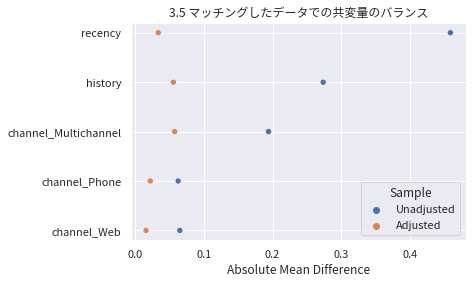

In [15]:
balance_df = pd.concat([
    pd.DataFrame({'Absolute Mean Difference': unadjusted_amd, 'Sample': 'Unadjusted'}),
    pd.DataFrame({'Absolute Mean Difference': after_matching_amd, 'Sample': 'Adjusted'})
])
fig = sns.scatterplot(data=balance_df, x='Absolute Mean Difference', y=balance_df.index, hue='Sample')
fig.set_title('3.5 マッチングしたデータでの共変量のバランス')
plt.show()

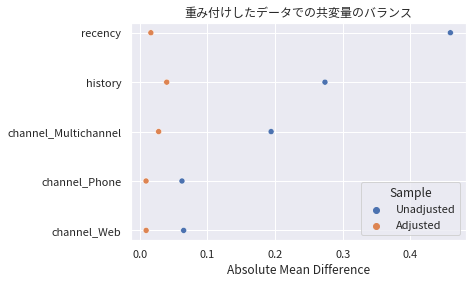

In [16]:
balance_df = pd.concat([
    pd.DataFrame({'Absolute Mean Difference': unadjusted_amd, 'Sample': 'Unadjusted'}),
    pd.DataFrame({'Absolute Mean Difference': after_weighted_amd, 'Sample': 'Adjusted'})
])
fig = sns.scatterplot(data=balance_df, x='Absolute Mean Difference', y=balance_df.index, hue='Sample')
fig.set_title('重み付けしたデータでの共変量のバランス')
plt.show()

## Analysis of email delivery logs using statistical models.

In [40]:
seed = 0
male_df_train, male_df_test = train_test_split(male_df,  test_size=0.5, random_state=seed)
male_df_train = male_df_train[male_df_train["treatment"]==0]

model = LogisticRegression(random_state=seed)
y_train = male_df_train["conversion"]
X_train = pd.get_dummies(
    male_df_train[['recency', 'history_segment', 'channel', 'zip_code']], columns=['history_segment', 'channel', 'zip_code'], drop_first=True
)
X_test = pd.get_dummies(
    male_df_test[['recency', 'history_segment', 'channel', 'zip_code']], columns=['history_segment', 'channel', 'zip_code'], drop_first=True
)

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
pred_cv_rank = pd.Series(y_pred, name="proba").rank(pct=True)

mail_assign = pred_cv_rank.apply(lambda x: np.random.binomial(1, x))

# create delivery log
male_df_test["mail_assign"] = mail_assign
male_df_test["ps"] = pred_cv_rank

ml_male_df = male_df_test[
    ((male_df_test["treatment"]==1) & (male_df_test["mail_assign"] == 1)) |
    ((male_df_test["treatment"]==0) & (male_df_test["mail_assign"] == 0))
].copy()

y = male_df_test.spend
X = male_df_test.treatment
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef_base = results.summary().tables[1]
coef_base = pd.read_html(coef_base.as_html(), header=0, index_col=0)[0]
coef_base

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.5585,0.149,3.752,0.0,0.267,0.850
treatment,0.9251,0.211,4.389,0.0,0.512,1.338


In [24]:
# セレクションバイアスの影響を受けている平均の比較
y = ml_male_df.spend
X = ml_male_df.treatment
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
coef

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.4881,0.326,1.497,0.135,-0.151,1.127
treatment,0.9596,0.467,2.057,0.040,0.045,1.875


## TPS

In [45]:
class ObtainedPropensityScoreMatching(PropensityScoreMatching):
    def __init__(self, bias_data, treatment, ps_score, random_state=1):
        super().__init__(bias_data, treatment, random_state)
        self.ps_score = ps_score

    def match(self):
        self.X = self.bias_data
        self.y = self.bias_data[self.treatment]

        all_data = pd.DataFrame({f"{self.treatment}": self.y, "ps_score":self.ps_score})
        treatments = all_data[f"{self.treatment}"].unique()

        if len(treatments) != 2:
            raise ValueError("Treatment must be binary.")

        group1_df = all_data[all_data[f"{self.treatment}"]==1]
        group1_indices = group1_df.index
        group1_df = group1_df.reset_index(drop=True)

        group0_df = all_data[all_data[f"{self.treatment}"]==0]
        group0_indices = group0_df.index
        group0_df = group0_df.reset_index(drop=True)

        threshold = all_data["ps_score"].std() * 0.2
        matched_group1_dfs = []
        matched_group0_dfs = []
        _group1_df = group1_df.copy()
        _group0_df = group0_df.copy()

        while True:
            nearest_neighbor_model = NearestNeighbors(n_neighbors=1)
            nearest_neighbor_model.fit(_group1_df["ps_score"].values.reshape(-1, 1))
            distances, indices = nearest_neighbor_model.kneighbors(_group0_df["ps_score"].values.reshape(-1, 1))

            distance_df = pd.DataFrame({"distance": distances.reshape(-1), "indices": indices.reshape(-1)})
            distance_df.index = _group0_df.index
            distance_df = distance_df.drop_duplicates(subset="indices")

            distance_df = distance_df[distance_df["distance"] < threshold]
            if len(distance_df) == 0:
                break

            group1_matched_indices = _group1_df.iloc[distance_df["indices"]].index.tolist()
            group0_matched_indices = distance_df.index
            matched_group1_dfs.append(_group1_df.loc[group1_matched_indices])
            matched_group0_dfs.append(_group0_df.loc[group0_matched_indices])
            _group1_df = _group1_df.drop(group1_matched_indices)
            _group0_df = _group0_df.drop(group0_matched_indices)

        group1_df.index = group1_indices
        group0_df.index = group0_indices
        matched_df = pd.concat([
            group1_df.iloc[pd.concat(matched_group1_dfs).index],
            group0_df.iloc[pd.concat(matched_group0_dfs).index]
        ]).sort_index()
        matched_indices = matched_df.index

        return self.X.loc[matched_indices], self.y.loc[matched_indices]

    def get_ipw_obtained_ps(self):
        self.X = self.bias_data
        self.y = self.bias_data[self.treatment]

        all_data = pd.DataFrame({f"{self.treatment}": self.y, "ps_score":self.ps_score})
        treatments = all_data[f"{self.treatment}"].unique()

        if len(treatments) != 2:
            raise ValueError("Treatment must be binary.")

        group1_df = all_data[all_data[f"{self.treatment}"]==1].copy()
        group0_df = all_data[all_data[f"{self.treatment}"]==0].copy()
        group1_df["weight"] = 1 / group1_df["ps_score"]
        group0_df["weight"] = 1 / (1 - group0_df["ps_score"])
        weights = pd.concat([group1_df, group0_df]).sort_index()["weight"].values

        return weights

In [37]:
obtained_ps_score_model = ObtainedPropensityScoreMatching(ml_male_df, "treatment",ps_score=ml_male_df.ps,  random_state=1)
matchX, matchy = obtained_ps_score_model.match()

In [43]:
# マッチング後のデータで効果の推定
y = matchX.spend
X = matchy
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef_obtained = results.summary().tables[1]
coef_obtained = pd.read_html(coef_obtained.as_html(), header=0, index_col=0)[0]
coef_obtained

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.5026,0.522,0.962,0.336,-0.522,1.527
treatment,0.9107,0.739,1.233,0.218,-0.538,2.359


In [44]:
coef_base["coef"][1] - coef_obtained["coef"][1]

0.01440000000000008

In [46]:
obtained_ps_score_model = ObtainedPropensityScoreMatching(ml_male_df, "treatment",ps_score=ml_male_df.ps,  random_state=1)
weights = obtained_ps_score_model.get_ipw_obtained_ps()

# 重み付きデータでの効果の推定
y = ml_male_df.spend
X = ml_male_df.treatment
X = sm.add_constant(X)
results = sm.WLS(y, X, weights=weights).fit()
coef_weight = results.summary().tables[1]
coef_weight = pd.read_html(coef_weight.as_html(), header=0, index_col=0)[0]
coef_weight

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.6154,0.303,2.032,0.042,0.022,1.209
treatment,0.3192,0.438,0.729,0.466,-0.539,1.177


In [47]:
coef_base["coef"][1] - coef_weight["coef"][1]

0.6059000000000001

In [48]:
## 調整前のAbsolute Mean Difference
unadjusted_df = pd.get_dummies(
    ml_male_df[['treatment', 'recency', 'history_segment', 'channel', 'zip_code']], columns=['history_segment', 'channel', 'zip_code']
)
unadjusted_amd = calculate_absolute_mean_difference(unadjusted_df, "treatment")

# IPWで重み付け後のAbsolute Mean Difference
# 重みのぶんレコードを増やして計算する（もっといいやり方を知りたい）
after_weighted_df = pd.get_dummies(
    ml_male_df[['treatment', 'recency', 'history_segment', 'channel', 'zip_code']], columns=['history_segment', 'channel', 'zip_code']
)
weights_int = (weights * 100).astype(int)
weighted_df = []
for i, value in enumerate(after_weighted_df.values):
    weighted_df.append(np.tile(value, (weights_int[i], 1)))
weighted_df = np.concatenate(weighted_df).reshape(-1, 15)
weighted_df = pd.DataFrame(weighted_df)
weighted_df.columns = after_weighted_df.columns
after_weighted_amd = calculate_absolute_mean_difference(weighted_df, "treatment")

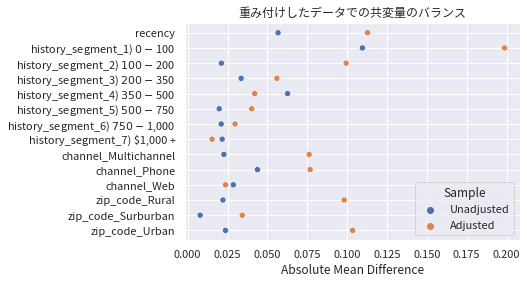

In [49]:
balance_df = pd.concat([
    pd.DataFrame({'Absolute Mean Difference': unadjusted_amd, 'Sample': 'Unadjusted'}),
    pd.DataFrame({'Absolute Mean Difference': after_weighted_amd, 'Sample': 'Adjusted'})
])
fig = sns.scatterplot(data=balance_df, x='Absolute Mean Difference', y=balance_df.index, hue='Sample')
fig.set_title('重み付けしたデータでの共変量のバランス')
plt.show()